In [13]:
import sys
sys.path.append('../')

from tasks import CustomTaskWrapper
from architecture import SequentialModel
from analysis_utils import load_checkpoints, import_checkpoint
from train import ping_dir

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from tqdm import tqdm

In [14]:
def get_components(X, k=-1, center = True, return_var = False):
    # If center = True, use PCA. If not true, use SVD, i.e. consider points relative to zero, not the mean.
    if center:
        return PCA(k).fit(X).components_

    # SVD case.
    _, S, Vt = np.linalg.svd(X, full_matrices=False)
    var = S**2 
    varrat = var / np.sum(var)
    dim = np.argwhere(np.cumsum(varrat) > .95)[0,0] + 1
    if k != -1:
        Vt = Vt[:dim]
        var = var[:dim]

    if return_var:
        return dim, Vt, var
    return dim, Vt
    
def unit_vector(vector, axis = -1):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector, axis = axis, keepdims = True)

def angle_between(v1, v2, axis = -1):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1, axis)
    v2_u = unit_vector(v2, axis)
    v1t = np.moveaxis(v1_u, axis, -1)
    v2t = np.moveaxis(v2_u, axis, -1)
    dot = (v1t[..., None, :] @ v2t[..., :, None])[..., 0, 0]
    return np.arccos(np.clip(dot, -1.0, 1.0))


In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(5, 100, batch_first = True)
        self.Wout = nn.Linear(100, 3)

    def forward(self, x, h0 = None):
        hidden, _ = self.rnn(x, h0)
        return self.Wout(hidden), hidden # [B, T, 3]

    def analysis_mode(self, X, target, h0 = None):
        # Intended for deep analysis of the GD flow:
        # Run RNN and compute losses, 
        # returning hidden, adjoints, outputs, unreduced losses, reduced loss.
        # Shapes: [B, T, H], [B, T, H], [B, T, O], [B, T, O], scalar.
        out, hidden = self.forward(X, h0) # A list.
        hidden.retain_grad()
        loss_fn = nn.MSELoss(reduction = 'none')
        loss_unreduced = loss_fn(out, target)
        loss = loss_unreduced.mean()
        loss.backward() # Perform BPTT.

        adjoint = hidden.grad # dL/dz defn of adjoint.
        return hidden, adjoint, out, loss_unreduced, loss

## Model definition (a GRU):

In [16]:
import copy

def eval(ch):
    model.load_state_dict(import_checkpoint(ch))
    model.zero_grad()
    hidden, adjoint, out, loss_unreduced, loss = model.analysis_mode(inputs.cuda(), targets.cuda())
    W_grad = 0. #W_grad = model.W.weight.grad.cpu().numpy()
    out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()
    adjoint = adjoint.detach().cpu().numpy()
    return model, hidden, adjoint, out, W_grad, loss.item(), loss_unreduced
    
def eval_next(model):
    # Do a small GD step and rerun model.
    eta = .01
    with torch.no_grad():  # Ensure no gradient tracking
        for param in model.parameters():
            if param.grad is not None:  # Only update if gradient exists
                param -= eta * param.grad
    return model(inputs.cuda())[1].detach().cpu().numpy()

# For Re-Training the Model

<h2>For a list of training hyperparameters run 'python train.py --help' or just look in train.py</h2>

torch.Size([3000, 120, 12])


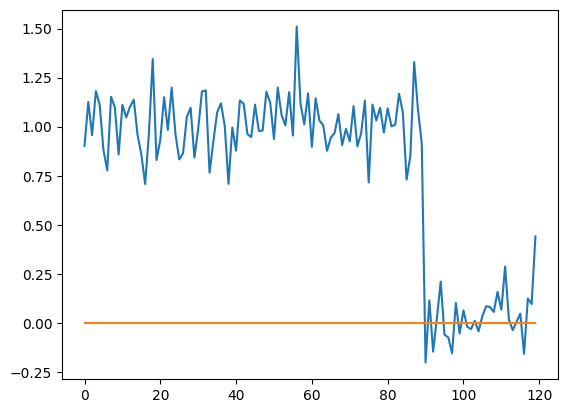

In [5]:
task  = CustomTaskWrapper('mix_multi_tasks', 200, use_noise = True, n_samples = 3000, n_spike = 20, T = 90)

inputs, targets = task()
plt.plot(inputs[0, :, 0])
plt.plot(targets[0, :, 0])
plt.show()

For training with my codebase. I found it to be quite a lot slower than using a vanilla GRU for now so disabled it:

In [6]:
# hyperparams = {
#     'prefix': 'test_mix_tasks_gru',
#     'save_freq': 100,
#     'grad_clip': 0.0001,
#     'lr': 1e-3,
#     'task_suite': 'custom',
#     'task': 'mix_multi_tasks',
#     'niters': 5000
# }

# from train import train
# train(hyperparams)

Vanilla GRU training:

In [7]:
model = Model().cuda()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.MSELoss()
losses = []

ping_dir('mix_tasks_gru/')
ping_dir('mix_tasks_gru/checkpoints/', clear = True)

checkpoints = []
for itr in tqdm(range(5000)):
    inputs, targets = task()
    inputs, targets = inputs.cuda(), targets.cuda()

    optim.zero_grad()
    out = model(inputs)[0]
    loss = loss_fn(out, targets)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), .0001)
    optim.step()

    losses.append(loss.item())
    if itr % 100 == 0:
        checkpoints.append(copy.deepcopy(model.state_dict()))
        torch.save(model.state_dict(), f'mix_tasks_gru/checkpoints/checkpoint_{itr}.pt')
        
plt.figure(figsize = (10, 3))
plt.plot(losses)
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 7

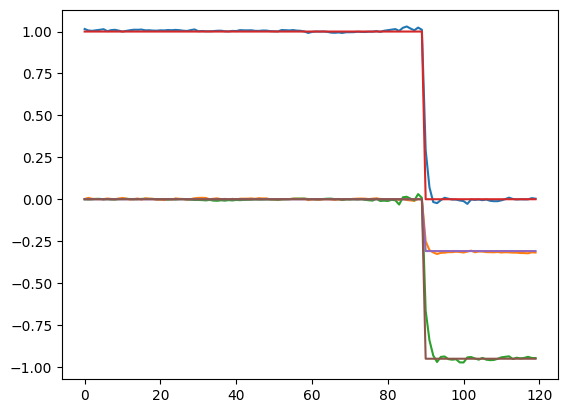

In [16]:
model.noise_std = 0.
plt.plot(out[0].cpu().detach())
plt.plot(targets[0].cpu().detach())

# Load model and generate testing set:

In [17]:
# ch_path = 'scale_sweeps_1_10/DelayMatchSample-v0/grid_20/'
ch_path = 'mix_tasks_gru/'
checkpoints = load_checkpoints(ch_path)[0]
checkpoints_all = list(checkpoints)
print(len(checkpoints))
checkpoints = checkpoints[::5] # Subset
model = Model().cuda()
model.load_state_dict(import_checkpoint(checkpoints[-1]))

0


IndexError: list index out of range

### Visualize the performance. Task code is contained in tasks.py and mix_multi_tasks.py

In [8]:
task_test  = CustomTaskWrapper('mix_multi_tasks', 1000, use_noise = False, n_samples = 1000, n_spike = 20, T = 90)
# task_test  = NeuroGymWrapper('DelayMatchSample-v0', 100)
inputs, targets = task_test()
out, hidden = model(inputs.cuda())
out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()

plt.figure(figsize = (10, 10))
for b in range(25):
    plt.subplot(5, 5, b + 1)
    plt.plot(out[b, :, 0])
    plt.plot(targets[b, :, 0])
plt.tight_layout()
plt.show()

RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 7

### This code splits up data (e.g. state, adjoint, input, target) into a dict of four sets of trajectories:

In [193]:
def get_splits(inputs):
    names = ['mem_pro', 'mem_anti', 'del_pro', 'del_anti']
    inds_tasks = [
        np.argwhere(np.logical_and(inputs[:, 0, 3] < .5, inputs[:, 0, 4] < .5))[0],
        np.argwhere(np.logical_and(inputs[:, 0, 3] > .5, inputs[:, 0, 4] < .5))[0],
        np.argwhere(np.logical_and(inputs[:, 0, 3] < .5, inputs[:, 0, 4] > .5))[0],
        np.argwhere(np.logical_and(inputs[:, 0, 3] > .5, inputs[:, 0, 4] > .5))[0]
    ]
    return {name: inds for name, inds in zip(names, inds_tasks)}

def split_data(splits, data):
    return {name: data[split] for name, split in splits.items()} # data could be task inputs, hidden state, etc. Split up into dict for four tasks.

task_flags = [(False, False), (False, True), (True, False), (True, True)] # (anti, delay)
splits = get_splits(inputs)
hidden_split = split_data(splits, hidden)
input_split = split_data(splits, inputs) # Syntax is (split, trajectories to split up).

In [194]:
from sklearn.decomposition import PCA
pallette = plt.get_cmap('tab20')(np.linspace(0, 1, 7))
def plot_with_periods(delay, anti, data, data_for_pca = None, nplot = 40, fixed_color = None):
    # data for pca allows us to fit the PCA to different data than the actual data that we project.
    if data_for_pca is None:
        data_for_pca = data
    pca = PCA(3).fit(data_for_pca.reshape(-1, data_for_pca.shape[-1]))
    proj = pca.transform(data.reshape(-1, data.shape[-1])).reshape((*data.shape[:-1], 3))
    
    for i in range(nplot):
        colors = pallette[:4] if not delay else pallette[[0, 1, 1, 2]]
        linestyle = 'dashed' if anti else 'solid'
        if fixed_color is not None:
            colors = [fixed_color] * 4
            linestyle = 'solid'
        for j in range(0, proj.shape[1], 30):
            plt.plot(proj[i, j:j+31, 0], proj[i, j:j+31, 1], proj[i, j:j+31, 2], color = colors[j // 30], linestyle = linestyle)

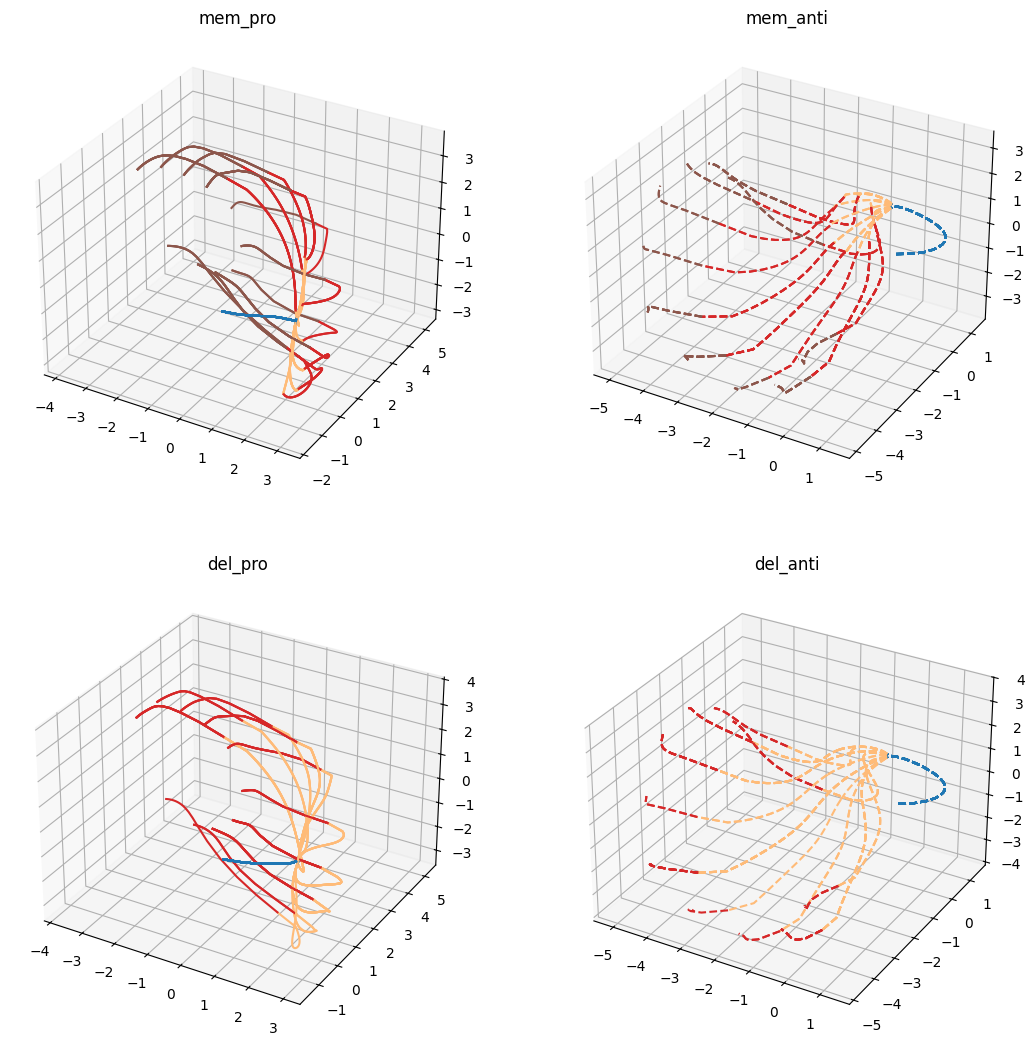

In [195]:
plt.figure(figsize = (13,13))
for i, (name, hidden_sub) in enumerate(hidden_split.items()):
    plt.subplot(2, 2, i+1, projection='3d')
    plot_with_periods(*task_flags[i], hidden_sub, hidden)
    plt.title(name)
plt.show()

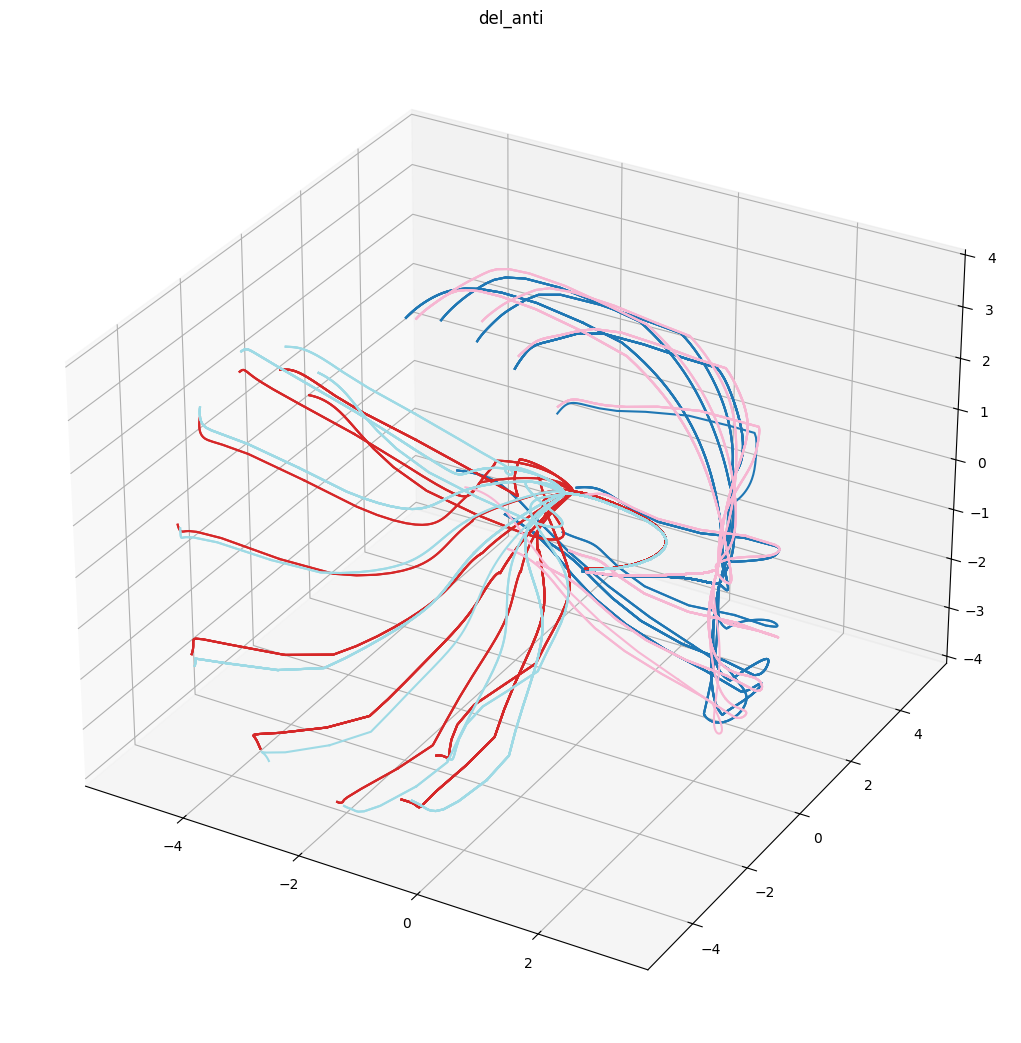

In [196]:
plt.figure(figsize = (13,13))
plt.subplot(1,1,1, projection='3d')

for i, (name, hidden_sub) in enumerate(hidden_split.items()):
    plot_with_periods(*task_flags[i], hidden_sub, hidden, fixed_color = pallette[2 * i])
    plt.title(name)
plt.show()

In [284]:
#                                  |
#                                / | \
#                           tsk1  tsk2  ...
#                            /|\  /|\    ...
#          [data1, data2, ...] ...

def bin_splits_based_on_input(data_split, inputs_split, nbins):
    # Further split up data (which is a dictionary with 4 tasks) based on input condition. 
    # Use a threshold to cluster similar inputs. 
    bin_centers = np.linspace(0, 2 * np.pi, nbins, endpoint = False)
    # print(bin_centers[-1])
    # bin_edges = np.linspace(0., 2 * np.pi, nbins+1)
    # bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
    data_bin_split = {}
    for (task_name, data), inputs in zip(data_split.items(), inputs_split.values()):
        stim2, stim1 = np.array(inputs[:, 30, 2]), np.array(inputs[:, 30, 1])
        angles = np.arctan2(stim2, stim1) + np.pi # Angle stim1 / stim2.
        diffs = bin_centers[:, None] - angles[None, :] # Difference between each angle to each bin, shape [nbins, nangles].

        best = np.argmin(np.abs(diffs), axis = 0)
        binned_data = {bin_centers[i] : data[best == i] for i in range(nbins)}
        data_bin_split[task_name] = binned_data
        
    return data_bin_split

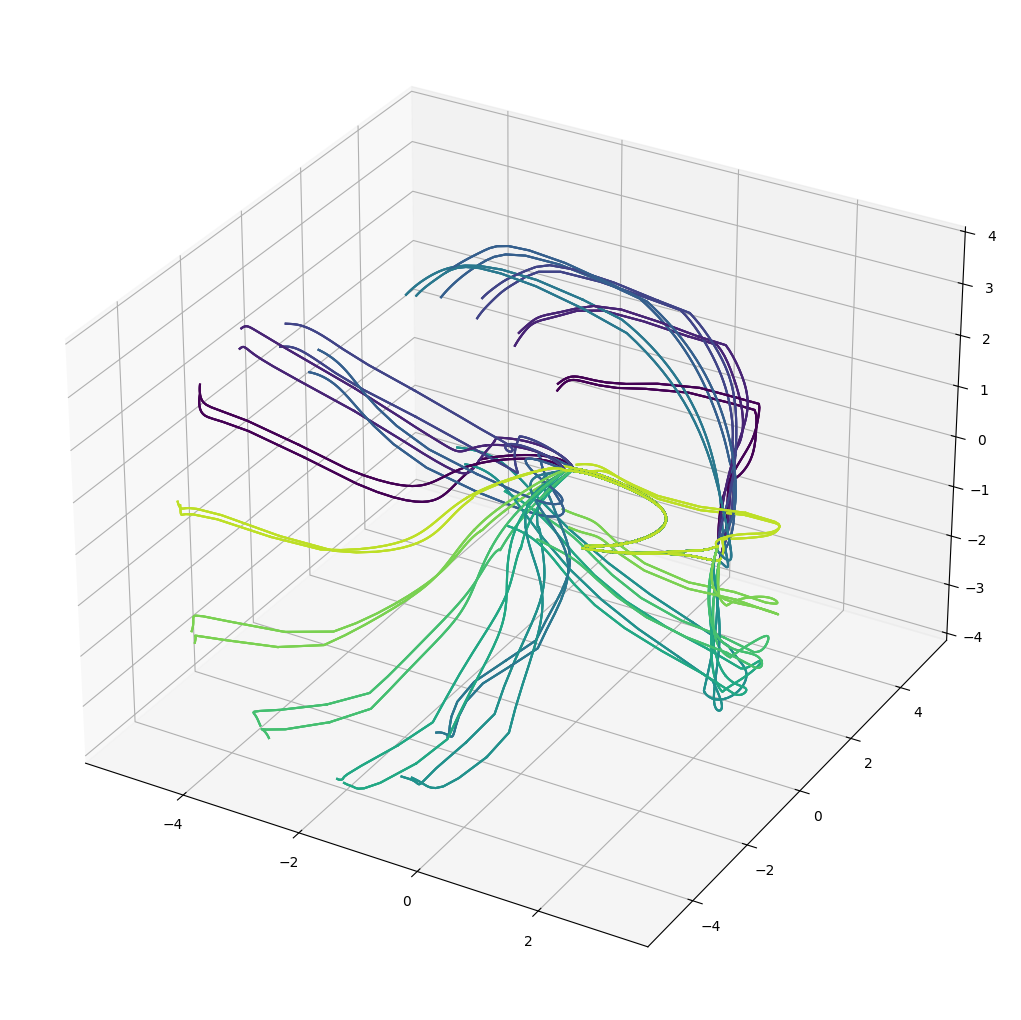

In [288]:

plt.figure(figsize = (13,13))
ax = plt.subplot(1,1,1, projection='3d')

# ax.view_init(90, 0)

for i, (name, binned_hidden) in enumerate(hidden_bin_split.items()):
    for ang, bin_trajs in binned_hidden.items():
    # bin0_trajs = list(binned_hidden.values())[0]
        plot_with_periods(*task_flags[i], bin_trajs, hidden, fixed_color = plt.get_cmap('viridis')(ang / (2 * np.pi)), nplot = 3)
plt.show()

dict_keys([0.0, 0.6283185307179586, 1.2566370614359172, 1.8849555921538759, 2.5132741228718345, 3.141592653589793, 3.7699111843077517, 4.39822971502571, 5.026548245743669, 5.654866776461628])
dict_keys([0.0, 0.6283185307179586, 1.2566370614359172, 1.8849555921538759, 2.5132741228718345, 3.141592653589793, 3.7699111843077517, 4.39822971502571, 5.026548245743669, 5.654866776461628])
tensor(2.3842e-07)
tensor(2.3842e-07)


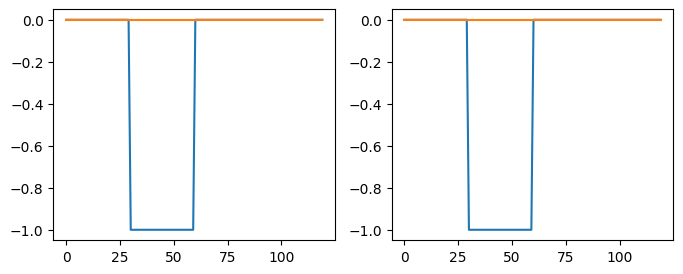

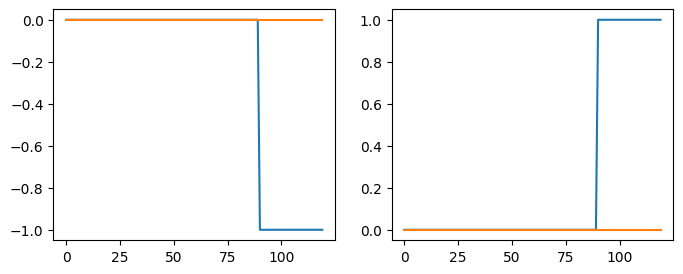

In [289]:
target_split = split_data(splits, targets)
target_bin_split = bin_splits_based_on_input(target_split, input_split, 10)


print(input_bin_split['mem_pro'].keys())
print(input_bin_split['mem_anti'].keys())

stim1 = list(input_bin_split['mem_pro'].values())[0][0, :, 1]
stim2 = list(input_bin_split['mem_pro'].values())[0][0, :, 2]
print(np.arctan2(stim2[30], stim1[30]) + np.pi)

stim1 = list(input_bin_split['mem_anti'].values())[0][0, :, 1]
stim2 = list(input_bin_split['mem_anti'].values())[0][0, :, 2]
print(np.arctan2(stim2[30], stim1[30]) + np.pi)

plt.figure(figsize = (8, 3))
plt.subplot(1,2,1)
plt.plot(list(input_bin_split['mem_pro'].values())[0][0, :, 1])
plt.plot(list(input_bin_split['mem_pro'].values())[0][0, :, 2])
plt.subplot(1,2,2)
plt.plot(list(input_bin_split['mem_anti'].values())[0][0, :, 1])
plt.plot(list(input_bin_split['mem_anti'].values())[0][0, :, 2])
plt.show()

plt.figure(figsize = (8, 3))
plt.subplot(1,2,1)
plt.plot(list(target_bin_split['mem_pro'].values())[0][0, :, 1])
plt.plot(list(target_bin_split['mem_pro'].values())[0][0, :, 2])
plt.subplot(1,2,2)
plt.plot(list(target_bin_split['mem_anti'].values())[0][0, :, 1])
plt.plot(list(target_bin_split['mem_anti'].values())[0][0, :, 2])
plt.show()

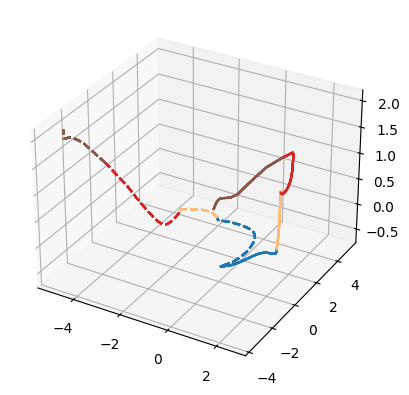

In [220]:
plt.axes(projection='3d')
plot_with_periods(*task_flags[0], list(hidden_bin_split['mem_pro'].values())[0], hidden, nplot = 10)
plot_with_periods(*task_flags[1], list(hidden_bin_split['mem_anti'].values())[0], hidden, nplot = 10)


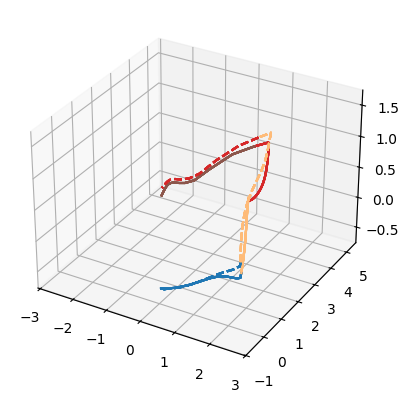

In [222]:
plt.axes(projection='3d')
plot_with_periods(*task_flags[0], list(hidden_bin_split['mem_pro'].values())[0], hidden, nplot = 10)
plot_with_periods(*task_flags[3], list(hidden_bin_split['del_pro'].values())[0], hidden, nplot = 10)


In [316]:
adjoint = eval(checkpoints_all[0])[2]
adjoint_split = split_data(splits, adjoint)
adjoint_bin_split = bin_splits_based_on_input(adjoint_split, input_split, 10)

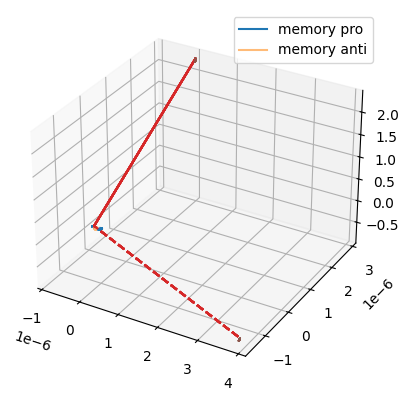

In [317]:
plt.axes(projection='3d')
plot_with_periods(*task_flags[0], list(adjoint_bin_split['mem_pro'].values())[0], adjoint, nplot = 10)
plot_with_periods(*task_flags[1], list(adjoint_bin_split['mem_anti'].values())[0], adjoint, nplot = 10)
plt.legend(['memory pro', 'memory anti'])
plt.show()

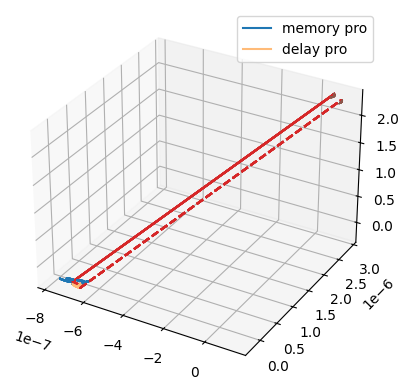

In [318]:
plt.axes(projection='3d')
plot_with_periods(*task_flags[0], list(adjoint_bin_split['mem_pro'].values())[0], adjoint, nplot = 10)
plot_with_periods(*task_flags[1], list(adjoint_bin_split['del_pro'].values())[0], adjoint, nplot = 10)
plt.legend(['memory pro', 'delay pro'])
plt.show()

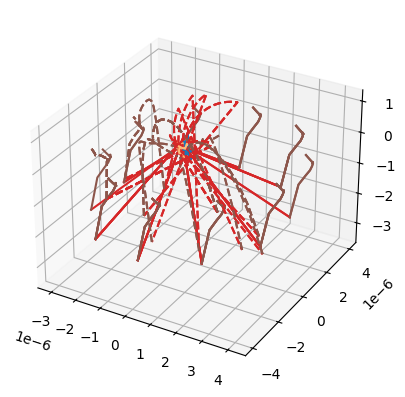

In [315]:
plt.axes(projection='3d')
plot_with_periods(*task_flags[0], adjoint_split['mem_pro'], adjoint, nplot = 30)
plot_with_periods(*task_flags[1], adjoint_split['mem_anti'], adjoint, nplot = 30)


TypeError: plot_with_periods() missing 1 required positional argument: 'data'

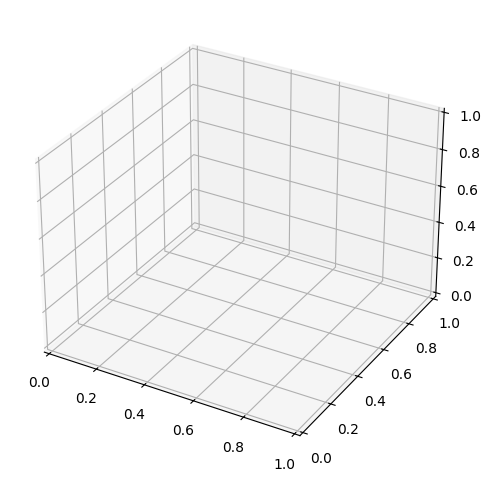

In [302]:
plt.figure(figsize = (13,13))
adjoint = eval(checkpoints_all[20])[2]
adjoint_split = split_data(splits, adjoint)
for i, (name, adjoint_sub) in enumerate(adjoint_split.items()):
    plt.subplot(2, 2, i+1, projection='3d')
    plot_with_periods(adjoint_sub, adjoint)
    plt.title(name)
plt.show()

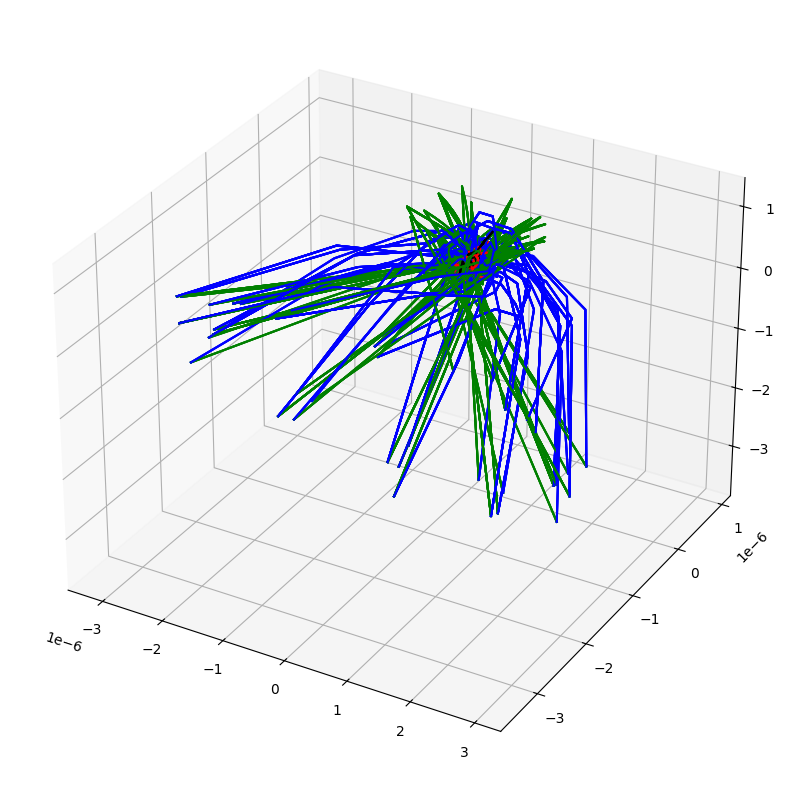

In [10]:
plt.figure(figsize = (10,10))
plt.axes(projection='3d')
plot_with_periods(adjoint, adjoint, nplot = 250)
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import rgb2hex
from matplotlib.gridspec import GridSpec

def find_segments(inputs, trial_idx=0):
    """Find boundaries where input values change in a piecewise constant signal
    
    Args:
        inputs: Array of shape (batch, time, features)
        trial_idx: Which trial to analyze (default: 0)
    
    Returns:
        segments: List of (start, end) tuples for each segment
    """
    # Get the inputs for a single trial
    trial_inputs = inputs[trial_idx, :, :]
    
    # Find where any input feature changes value
    changes = np.where(np.abs(np.diff(trial_inputs, axis=0)).sum(axis=1) > 0)[0]
    
    # Add start and end points to create segment boundaries
    boundaries = [0] + [i+1 for i in changes] + [trial_inputs.shape[0]]
    
    # Create segments as (start, end) tuples
    segments = [(boundaries[i], boundaries[i+1]) for i in range(len(boundaries)-1)]
    
    return segments

def get_segment_colors(cmap_name, num_segments):
    """Generate segment colors from a colormap, avoiding very light colors
    
    Args:
        cmap_name: Name of the matplotlib colormap
        num_segments: Number of segments to generate colors for
    
    Returns:
        List of hex color strings
    """
    cmap = plt.colormaps[cmap_name]
    # Skip the first 30% of the colormap to avoid very light colors
    min_value = 0.3
    
    if num_segments == 1:
        return [rgb2hex(cmap(0.7)[:3])]
    
    colors = []
    for i in range(num_segments):
        # Scale position from min_value to 1.0
        position = min_value + (i / (num_segments - 1)) * (1.0 - min_value)
        colors.append(rgb2hex(cmap(position)[:3]))
    
    return colors

def plot_task_segments(hidden_split, input_split, data_for_pca=None, nplot=5, figsize=(18, 15)):
    """Plot PCA of hidden states for each task, colored by input segments
    
    Args:
        hidden_split: Dictionary mapping task names to hidden state arrays (batch, time, features)
        input_split: Dictionary mapping task names to input arrays (batch, time, features)
        data_for_pca: Optional data to fit PCA (defaults to all hidden states combined)
        nplot: Number of trials to plot per task
        figsize: Figure size
        
    Returns:
        Dictionary of results for each task
    """
    task_names = list(hidden_split.keys())
    
    # Fit PCA to all data if not provided
    if data_for_pca is None:
        all_hidden = np.vstack([h.reshape(-1, h.shape[-1]) for h in hidden_split.values()])
        pca = PCA(3).fit(all_hidden)
    else:
        pca = PCA(3).fit(data_for_pca)
    
    # Set up figure with custom grid layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(4, 2, width_ratios=[3, 1])  # 3D plot gets more width
    
    results = {}
    
    # Plot each task
    for i, task_name in enumerate(task_names):
        hidden = hidden_split[task_name]
        inputs = input_split[task_name]
        
        # Find segments and generate colors
        segments = find_segments(inputs)
        segment_colors = get_segment_colors('viridis', len(segments))
        
        # Project hidden states using PCA
        proj = pca.transform(hidden.reshape(-1, hidden.shape[-1])).reshape(*hidden.shape[:-1], 3)
        
        # Create 3D plot for hidden states
        ax1 = fig.add_subplot(gs[i, 0], projection='3d')
        
        # Plot each trial and segment with appropriate colors
        for trial in range(min(nplot, hidden.shape[0])):
            for j, ((start, end), color) in enumerate(zip(segments, segment_colors)):
                ax1.plot(
                    proj[trial, start:end+1, 0],
                    proj[trial, start:end+1, 1],
                    proj[trial, start:end+1, 2],
                    color=color,
                    alpha=0.8,
                    linewidth=2,
                    label=f"Segment {j}" if trial == 0 else ""
                )
        
        ax1.set_title(f'{task_name} - Hidden State Trajectory')
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        
        # Create timeseries plot for inputs
        ax2 = fig.add_subplot(gs[i, 1])
        
        # Plot input features
        for feat in range(inputs.shape[2]):
            ax2.plot(inputs[0, :, feat], label=f'Input {feat}')
        
        # Add boundaries and shading
        for (start, end), color in zip(segments, segment_colors):
            ax2.axvspan(start, end, alpha=0.2, color=color)
            if start > 0:  # Skip first boundary
                ax2.axvline(x=start, color='k', linestyle='--', alpha=0.5)
        
        ax2.set_title(f'{task_name} - Input Signal')
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Input Value')
        
        # Add legend for first task only
        if i == 0:
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Store results
        results[task_name] = {
            'pca': pca,
            'segments': segments,
            'colors': segment_colors
        }
    
    plt.tight_layout()
    return results

def plot_combined_task_segments(hidden_split, input_split, data_for_pca=None, nplot=3, figsize=(20, 12)):
    """Plot all tasks in a single 3D visualization with color-coded segments
    
    Args:
        hidden_split: Dictionary mapping task names to hidden state arrays
        input_split: Dictionary mapping task names to input arrays
        data_for_pca: Optional data to fit PCA
        nplot: Number of trials to plot per task
        figsize: Figure size
        
    Returns:
        PCA object and segments dictionary
    """
    task_names = list(hidden_split.keys())
    task_cmaps = ['Blues', 'Greens', 'Reds', 'Purples']  # One colormap per task
    
    # Fit PCA to all data if not provided
    if data_for_pca is None:
        all_hidden = np.vstack([h.reshape(-1, h.shape[-1]) for h in hidden_split.values()])
        pca = PCA(3).fit(all_hidden)
    else:
        pca = PCA(3).fit(data_for_pca)
    
    # Set up figure with custom grid layout
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 3, width_ratios=[3, 1, 1])
    
    # Create 3D plot for all tasks
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    all_segments = {}
    
    # Plot all tasks in the 3D plot
    for i, (task_name, cmap_name) in enumerate(zip(task_names, task_cmaps)):
        hidden = hidden_split[task_name]
        inputs = input_split[task_name]
        
        # Project hidden states
        proj = pca.transform(hidden.reshape(-1, hidden.shape[-1])).reshape(*hidden.shape[:-1], 3)
        
        # Find segments and generate colors
        segments = find_segments(inputs)
        all_segments[task_name] = segments
        segment_colors = get_segment_colors(cmap_name, len(segments))
        
        # Plot each trial and segment
        for trial in range(min(nplot, hidden.shape[0])):
            for j, ((start, end), color) in enumerate(zip(segments, segment_colors)):
                label = f"{task_name} - Segment {j}" if trial == 0 else ""
                ax1.plot(
                    proj[trial, start:end+1, 0],
                    proj[trial, start:end+1, 1],
                    proj[trial, start:end+1, 2],
                    color=color,
                    alpha=0.8,
                    linewidth=2,
                    label=label
                )
    
    ax1.set_title('Combined Hidden State Trajectories')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    
    # Create small input plots for each task
    for i, task_name in enumerate(task_names):
        row = i // 2
        col = (i % 2) + 1
        ax = fig.add_subplot(gs[row, col])
        
        inputs = input_split[task_name]
        segments = all_segments[task_name]
        segment_colors = get_segment_colors(task_cmaps[i], len(segments))
        
        # Plot input features
        for feat in range(inputs.shape[2]):
            ax.plot(inputs[0, :, feat], label=f'Input {feat}')
        
        # Add boundaries and shading
        for (start, end), color in zip(segments, segment_colors):
            ax.axvspan(start, end, alpha=0.2, color=color)
            if start > 0:  # Skip first boundary
                ax.axvline(x=start, color='k', linestyle='--', alpha=0.5)
        
        ax.set_title(f'{task_name} - Input Signal')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Input Value')
        
        # Add legend for first task only
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return pca, all_segments

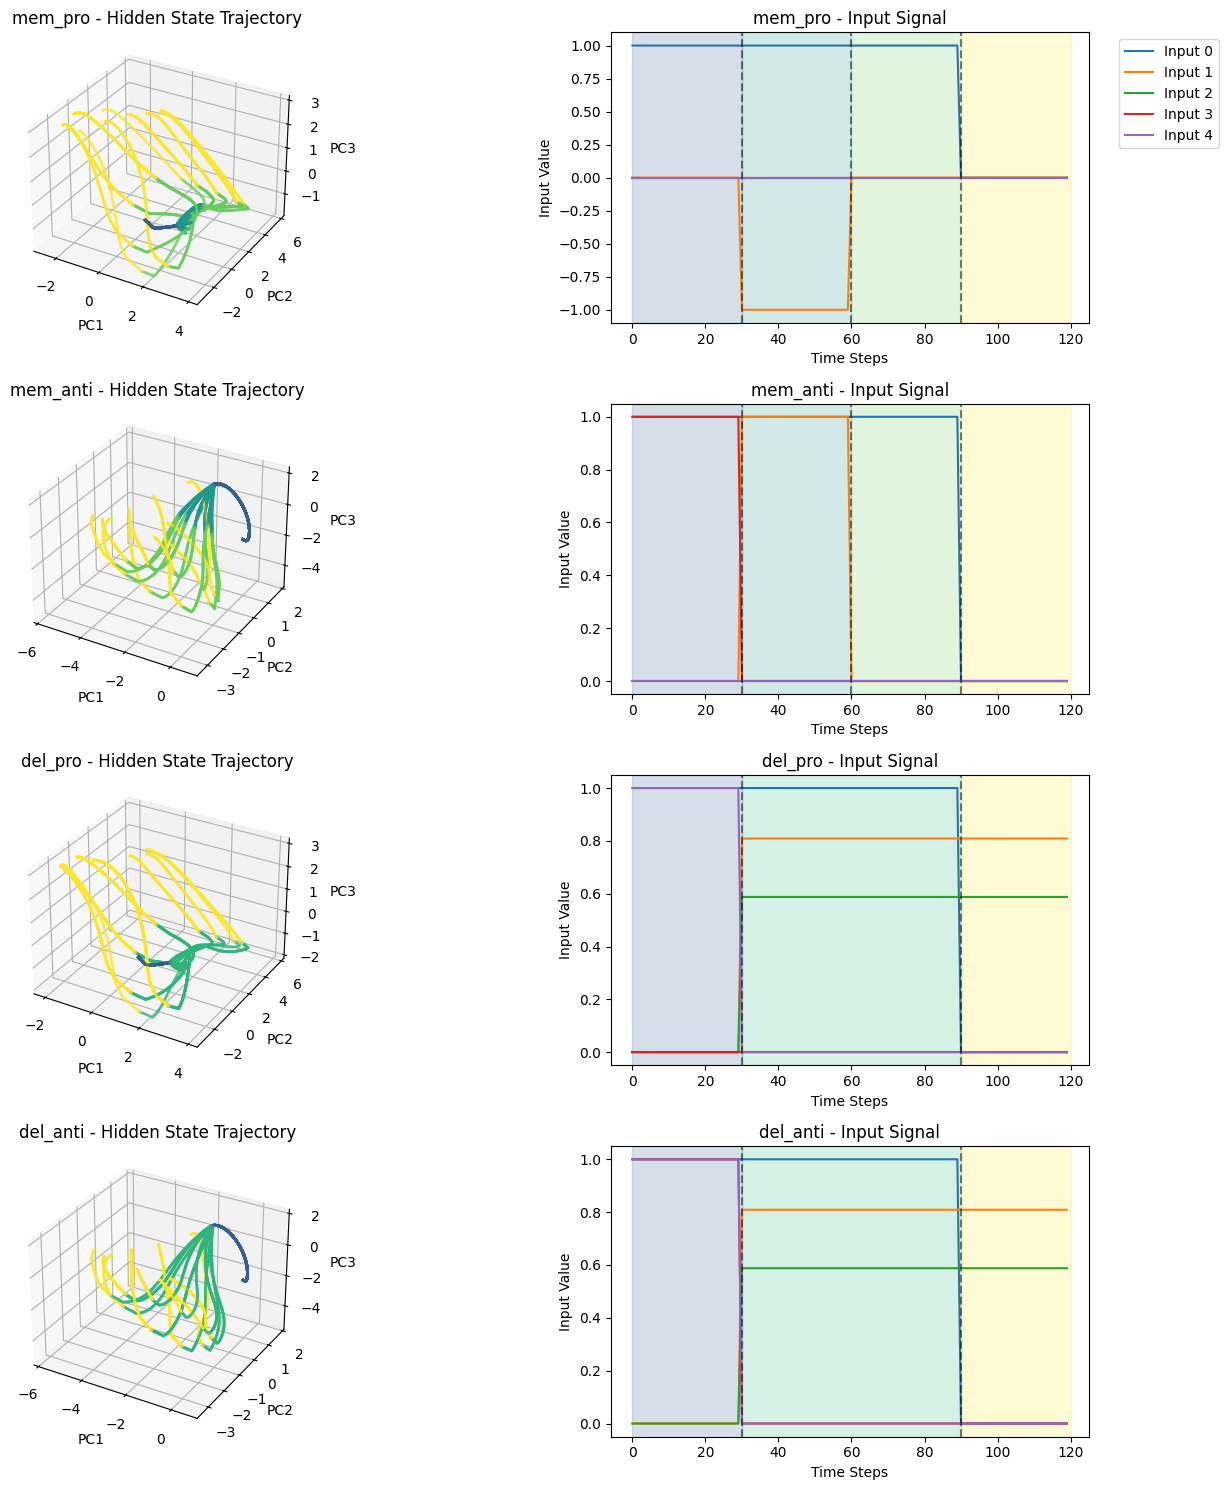

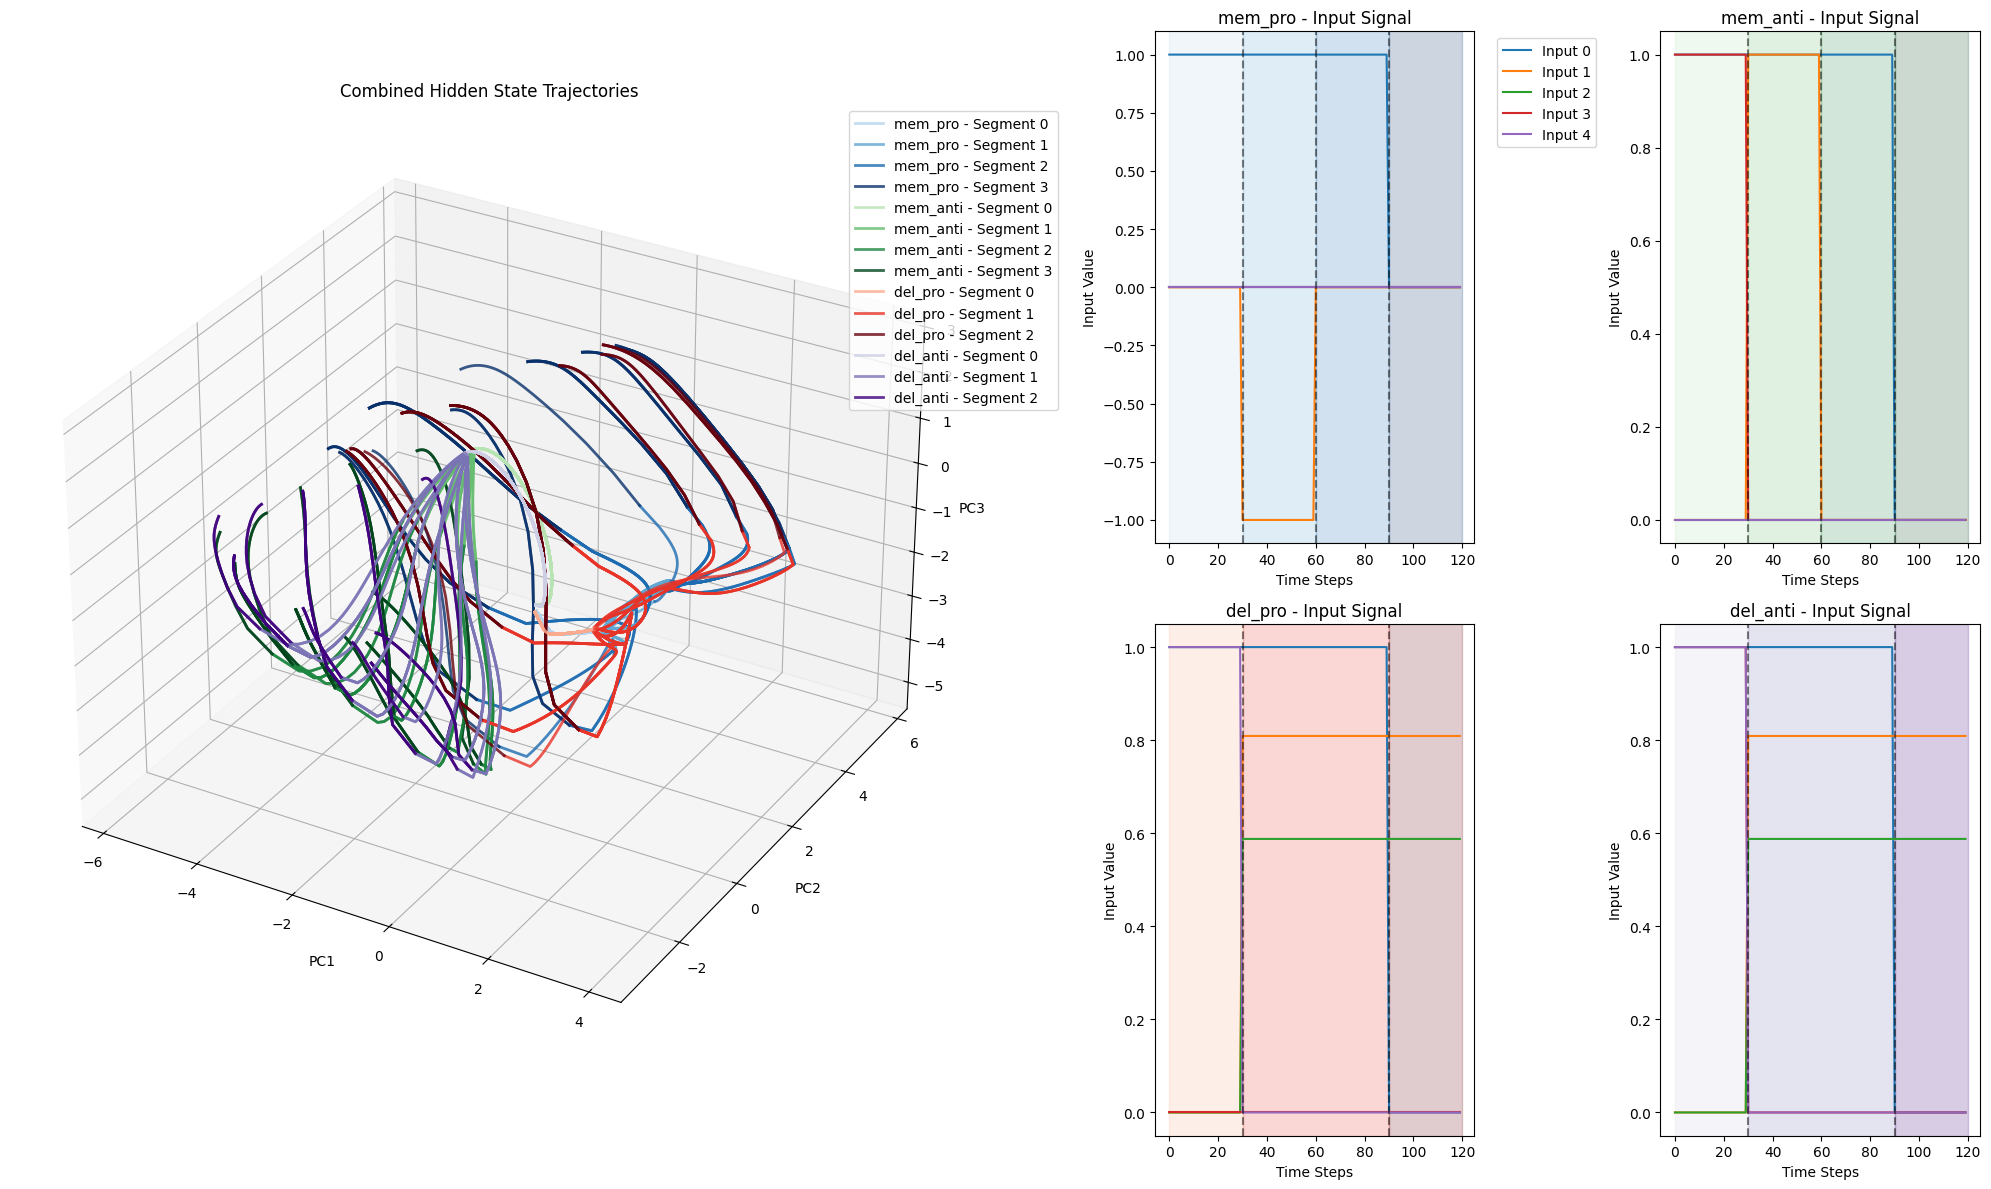

In [27]:
# Using your data splits
splits = get_splits(inputs)
hidden_split = split_data(splits, hidden)
input_split = split_data(splits, inputs)
 
# Individual task plots
results = plot_task_segments(hidden_split, input_split, nplot=30)
 
# Combined visualization
pca, segments = plot_combined_task_segments(hidden_split, input_split, nplot=30)

In [ ]:
from task_segment_visualization import *

# Using your data splits
splits = get_splits(inputs)
hidden_split = split_data(splits, hidden)
input_split = split_data(splits, inputs)
 
# Individual task plots
results = plot_task_segments(hidden_split, input_split)
 
# Combined visualization
pca, segments = plot_combined_task_segments(hidden_split, input_split)

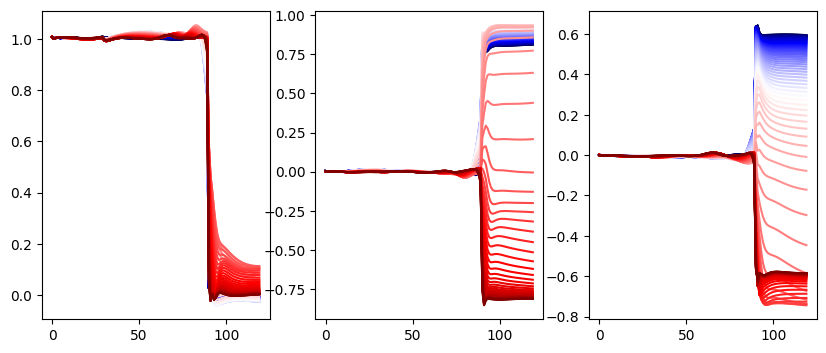

In [35]:
# Interpolate between two input modalities.
inp0 = input_split['del_anti'][0]
inps_lerp = torch.stack([inp0] * 100)
inps_lerp[:, :, 3] = inps_lerp[:, :, 3] * torch.linspace(0., 1., 100)[:, None]
inps_lerp = torch.flip(inps_lerp, [0]) # Pro -> Anti order.

outs_lerp = model(inps_lerp.cuda())[0].detach().cpu().numpy()
plt.figure(figsize = (10, 4))
cmap = plt.get_cmap('seismic')
for i in range(outs_lerp.shape[-1]):
    plt.subplot(1, 3, i + 1)
    for j in range(outs_lerp.shape[0]):
        plt.plot(outs_lerp[j, :, i], color = cmap(j / (outs_lerp.shape[0] - 1.)))
plt.show()

100%|██████████| 9/9 [00:01<00:00,  4.58it/s]


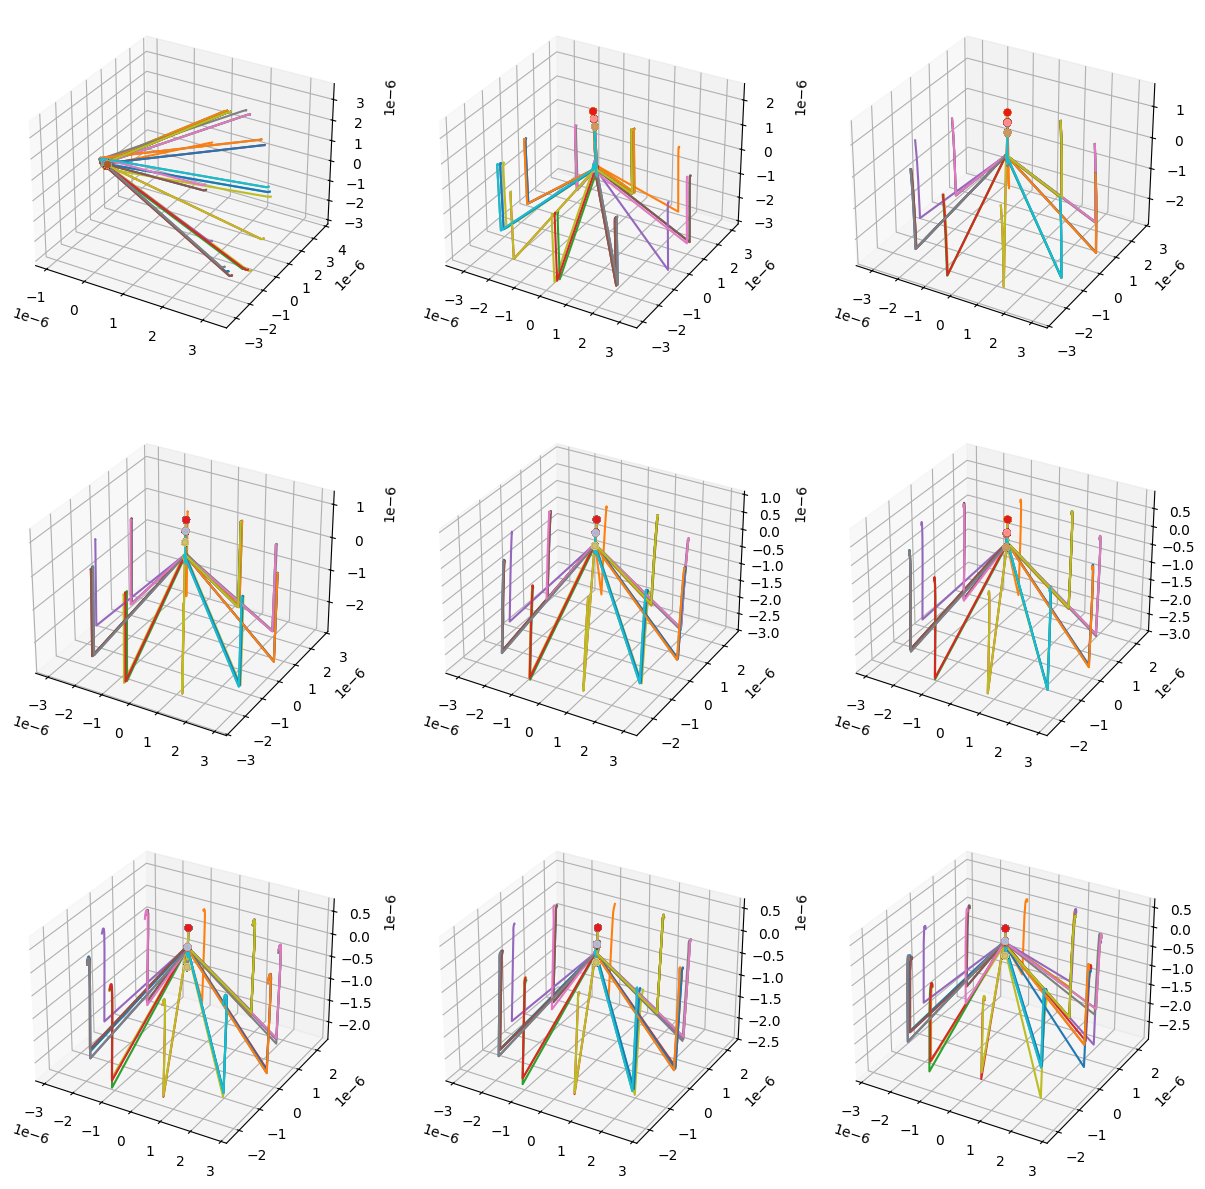

In [128]:
from sklearn.decomposition import PCA

plt.figure(figsize = (15, 15))
inc = len(checkpoints) // 9
for i in tqdm(range(9)):
    model.load_state_dict(import_checkpoint(checkpoints_all[inc * i]))

    plt.subplot(3, 3, i + 1, projection = '3d')
    hidden, adjoint, out = model.analysis_mode(inputs.cuda(), targets.cuda())[:3]
    out, hidden = out.detach().cpu().numpy(), hidden.detach().cpu().numpy()
    adjoint = adjoint.detach().cpu().numpy()[:, ::-1] # Reverse time

    proj = PCA(3).fit_transform(adjoint.reshape(-1, hidden.shape[-1])).reshape((*hidden.shape[:-1], 3))

    for i in range(40):
        plt.plot(proj[i, :, 0], proj[i, :, 1], proj[i, :, 2])
plt.show()

## Evaluate the model over training. See eval at top of this notebook.

In [16]:
pairs = []
grads = []
losses = []
z_next = []
for ch in tqdm(checkpoints_all):
    model, hidden, adjoint, out, W_grad, loss, loss_unreduced = eval(ch)
    grads.append(W_grad)
    losses.append(loss)
    pairs.append([hidden, adjoint])                                                     
    hidden_next = eval_next(model)
    z_next.append(hidden_next)

100%|██████████| 50/50 [00:06<00:00,  8.27it/s]


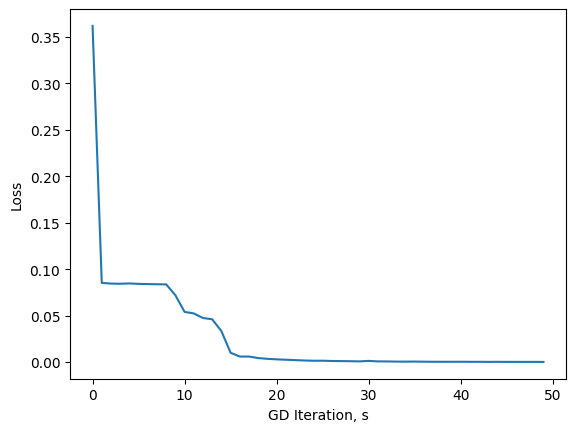

In [17]:
plt.plot(losses)
plt.xlabel('GD Iteration, s')
plt.ylabel('Loss')
plt.show()

50


100%|██████████| 50/50 [00:05<00:00,  8.38it/s]


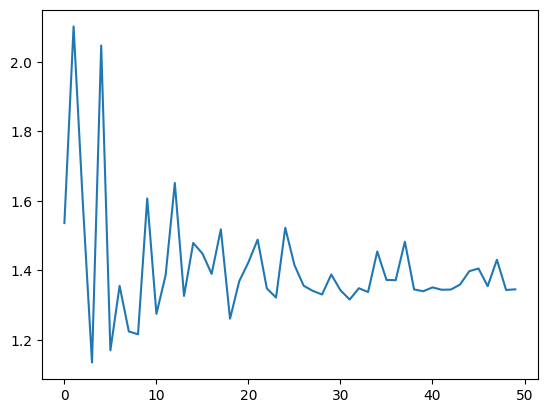

In [41]:

# mu_dz = np.mean(dz, (0, 1))
# mu_z0 = np.mean(z0, (0, 1))
# mu_a0 = np.mean(a0, (0, 1))

print(len(checkpoints_all))
pairs, z_next = [], []
for ch in tqdm(checkpoints_all):
    pairs.append(eval(ch)[1:3])
    hidden_next = eval_next(model)
    z_next.append(hidden_next)
    
plt.plot([angle_between(np.mean(z0, (0, 1)), np.mean(a0, (0, 1))) for (z0, a0) in pairs])

In [42]:
n = pairs[0][0].shape[-1]
get_dir = lambda x, k: get_components(x.reshape(-1, n), k+1, False)[k]
dirs_a0 = [get_components(a0.reshape(-1, n), 10, False) for _, a0 in pairs]
dirs_z0 = [get_components(z0.reshape(-1, n), 10, False) for z0, _ in pairs]
dirs_dz = [get_components((z2 - z1).reshape(-1, n), 10, False) for (z1, _), z2 in zip(pairs, z_next)]

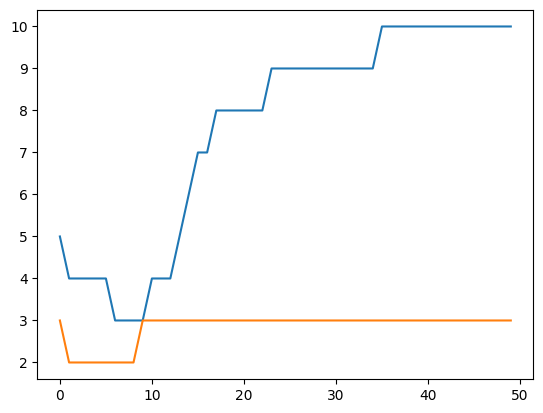

In [43]:
plt.plot([dim for dim, _ in dirs_z0])
plt.plot([dim for dim, _ in dirs_a0])
plt.show()

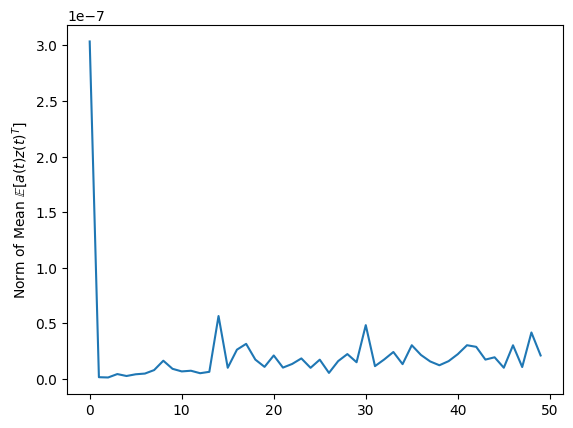

In [44]:
def safe_mean_outer(X, Y, axis):
    n1, n2 = X.shape[axis], Y.shape[axis]
    mat = np.zeros((n1, n2))
    Xax, Yax = np.moveaxis(X, axis, 0), np.moveaxis(Y, axis, 0)
    for i in range(n1):
        mat[i, :] = np.mean(Xax[i:i+1] * Yax)
    return mat

outers = [safe_mean_outer(a0, z0, -1) for z0, a0 in pairs]
outer_norms = [np.linalg.norm(outer) for outer in outers]
plt.plot(outer_norms)
plt.ylabel('Norm of Mean $\\mathbb{E}[a(t) z(t)^T]$')
plt.show()

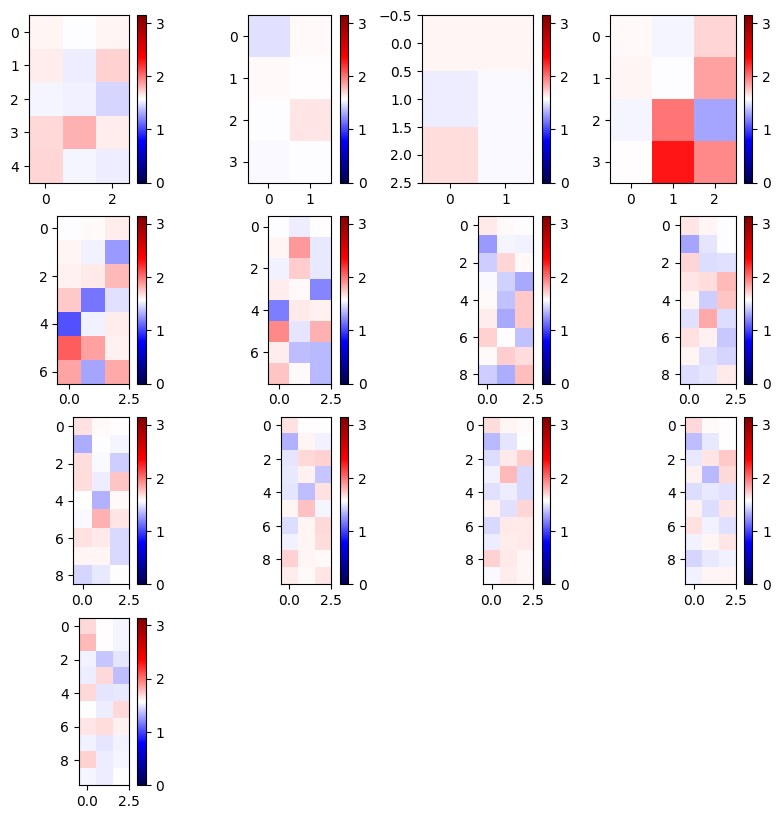

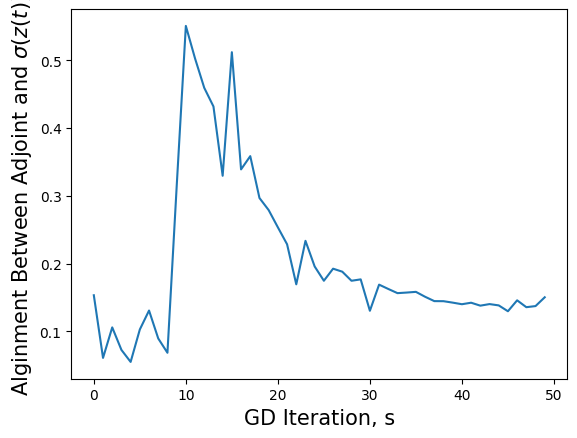

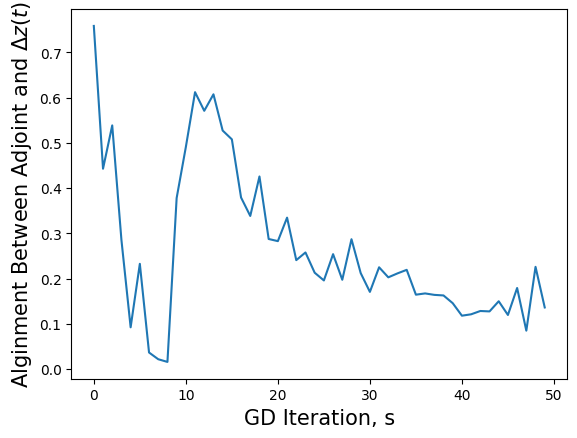

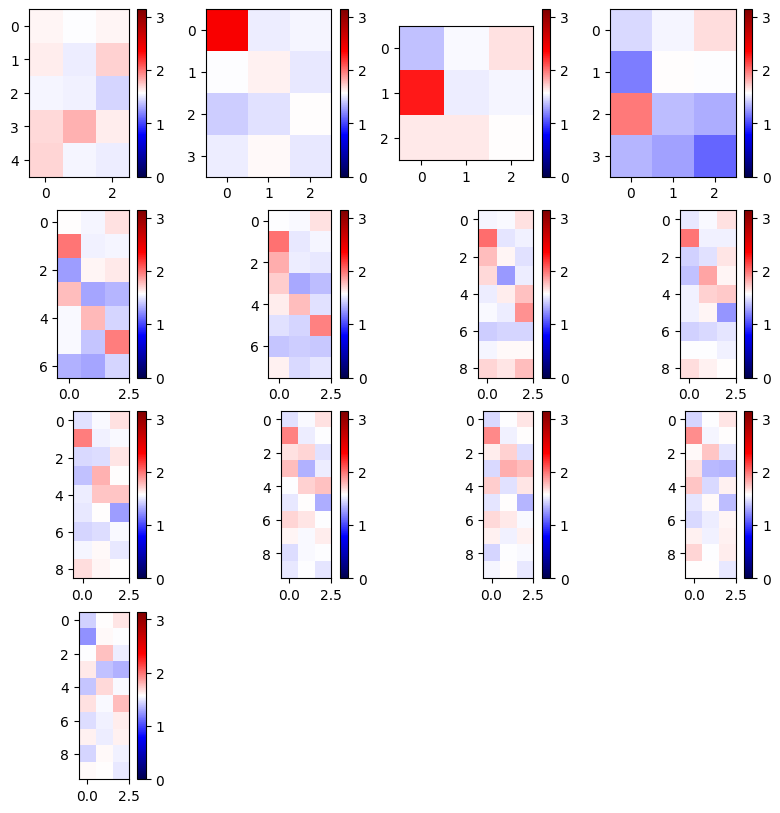

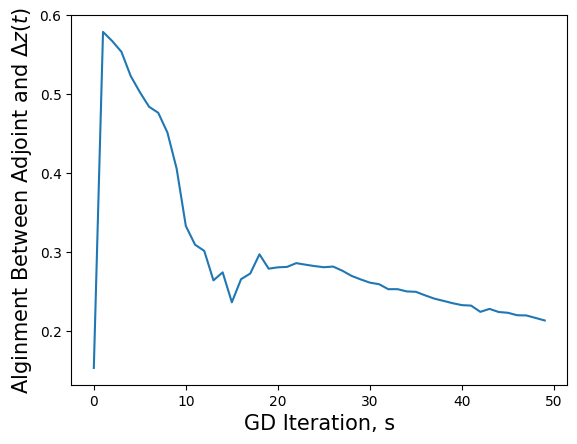

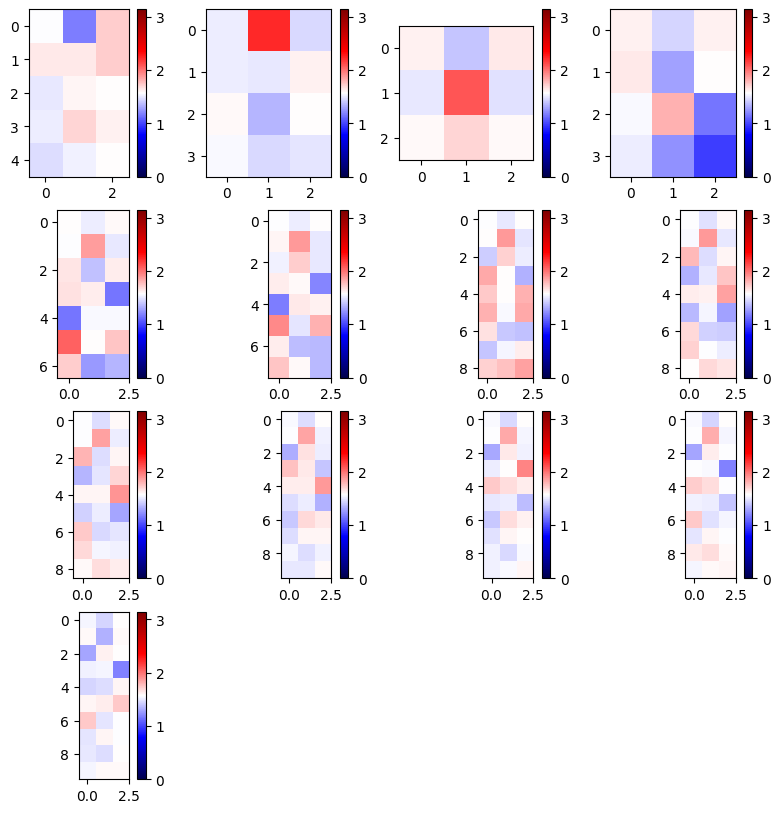

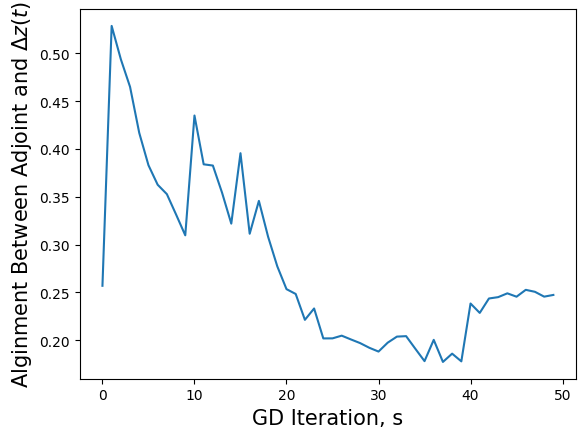

In [45]:
def analyze_relation(X, Y):
    grids = []
    best_diffs = []
    for s in range(len(X)):
        dim1, x = X[s]
        dim2, y = Y[s]
        grid = [[angle_between(dir1, dir2) for dir1 in x[:dim1]] for dir2 in y[:dim2]]
        grids.append(grid)
        best_diff = np.max(np.abs(np.array(grid) - np.pi/2) / (np.pi/2))
        best_diffs.append(best_diff)
    return grids, best_diffs

grids, best_diffs = analyze_relation(dirs_a0, dirs_z0)

plt.figure(figsize = (10, 10))
for idx, grid in enumerate(grids[::4]):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
    plt.colorbar()
plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\sigma(z(t))$', fontsize = 15)
plt.show()

grids, best_diffs = analyze_relation(dirs_a0, dirs_dz)

# for idx, grid in enumerate(grids):
#     plt.subplot(3, 4, idx + 1)
#     plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
# plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\Delta z(t)$', fontsize = 15)
plt.show()

init_a0_dir = [dirs_a0[0]] * len(dirs_a0)
init_a0_dir = [(10, d) for _, d in init_a0_dir]
grids, best_diffs = analyze_relation(init_a0_dir, dirs_z0)

plt.figure(figsize = (10, 10))
for idx, grid in enumerate(grids[::4]):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
    plt.colorbar()
plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\Delta z(t)$', fontsize = 15)
plt.show()


init_a0_dir = [dirs_a0[20]] * len(dirs_a0)
init_a0_dir = [(10, d) for _, d in init_a0_dir]
grids, best_diffs = analyze_relation(init_a0_dir, dirs_z0)

plt.figure(figsize = (10, 10))
for idx, grid in enumerate(grids[::4]):
    plt.subplot(4, 4, idx + 1)
    plt.imshow(grid, vmin = 0, vmax = np.pi, cmap = 'seismic')
    plt.colorbar()
plt.show()

plt.plot(best_diffs)
plt.xlabel('GD Iteration, s', fontsize = 15)
plt.ylabel('Alginment Between Adjoint and $\\Delta z(t)$', fontsize = 15)
plt.show()

In [146]:
init_dim_adjoint, init_dirs_adjoint = get_components(pairs[0][1].reshape(-1, n), center = False)
proj = np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))
# print(proj.sum(1)[0])
# proj = proj / proj.sum(1, keepdims = True)
plt.figure(figsize = (9, 4))
plt.imshow(proj[:, :20], aspect = 'auto')
plt.colorbar()
plt.xlabel('Initial Adjoint Directions', fontsize = 15)
plt.ylabel('Final State Directions', fontsize = 15)
plt.show()


ValueError: shapes (5,) and (100,) not aligned: 5 (dim 0) != 100 (dim 0)

In [47]:
proj = 0.
for i in tqdm(range(len(pairs))):
    init_dim_adjoint, init_dirs_adjoint = get_components(pairs[i][1].reshape(-1, n), center = False)
    proj = proj + np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))

100%|██████████| 50/50 [01:26<00:00,  1.72s/it]


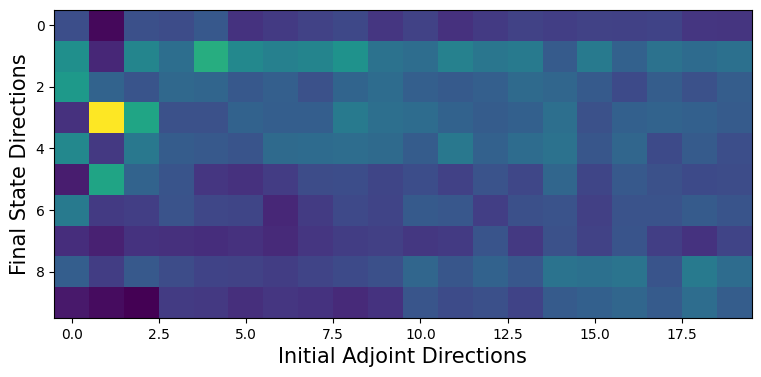

In [50]:
# proj = proj / proj.sum(1, keepdims = True)
plt.figure(figsize = (9, 4))
plt.imshow(proj[:, :20], aspect = 'auto')
# plt.colorbar()
plt.xlabel('Initial Adjoint Directions', fontsize = 15)
plt.ylabel('Final State Directions', fontsize = 15)
plt.show()

In [51]:
proj = 0.
most_aligned = []
mags = []
for i in tqdm(range(len(pairs))):
    init_dim_adjoint, init_dirs_adjoint, vars = get_components(pairs[i][1].reshape(-1, n), center = False, return_var = True)
    proj_i = np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))
    z_ind, a_ind = np.unravel_index(np.argmax(proj_i), proj_i.shape)
    most_aligned.append(z_ind)
    mags.append(vars[a_ind])

 52%|█████▏    | 26/50 [00:43<00:39,  1.65s/it]


KeyboardInterrupt: 

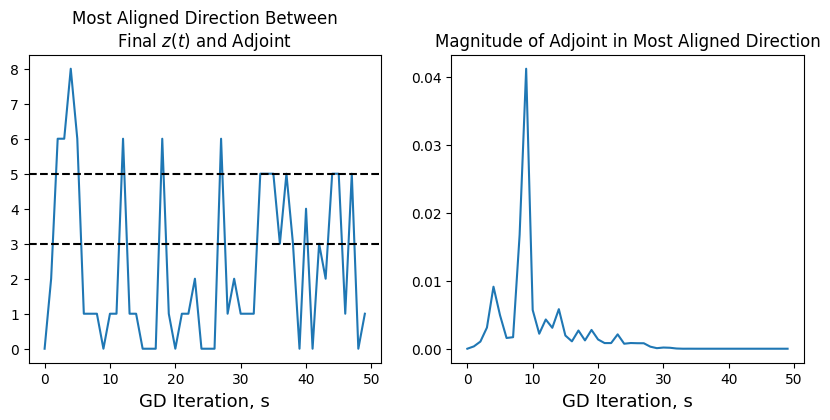

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(most_aligned)
plt.title('Most Aligned Direction Between\nFinal $z(t)$ and Adjoint')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.axhline(3, color = 'black', linestyle = 'dashed')
plt.axhline(5, color = 'black', linestyle = 'dashed')

plt.subplot(1,2,2)
plt.plot(mags)
plt.title('Magnitude of Adjoint in Most Aligned Direction')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.show()

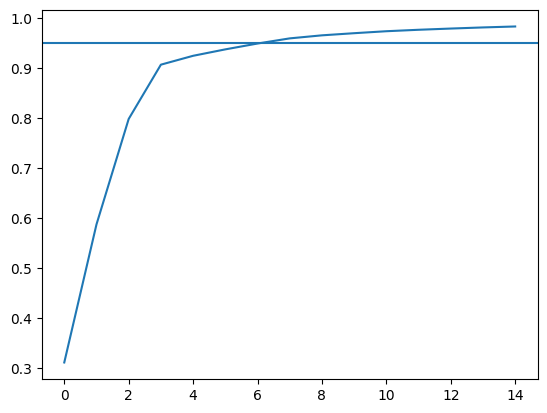

In [ ]:
init_dim_adjoint, init_dirs_adjoint, vars = get_components(pairs[-1][0].reshape(-1, n), center = False, return_var = True)
plt.plot(np.cumsum(vars / np.sum(vars))[:15])
plt.axhline(.95)
plt.show()

In [ ]:
proj = 0.
most_aligned = []
mags = []
for i in tqdm(range(len(pairs))):
    init_dim_adjoint, init_dirs_adjoint, vars = get_components(pairs[i][0].reshape(-1, n), center = False, return_var = True)
    proj_i = np.abs(np.array([[np.inner(dir1, dir2) for dir1 in init_dirs_adjoint] for dir2 in dirs_z0[-1][1]]))
    z_ind, a_ind = np.unravel_index(np.argmax(proj_i), proj_i.shape)
    most_aligned.append(z_ind)
    mags.append(vars[a_ind])

100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


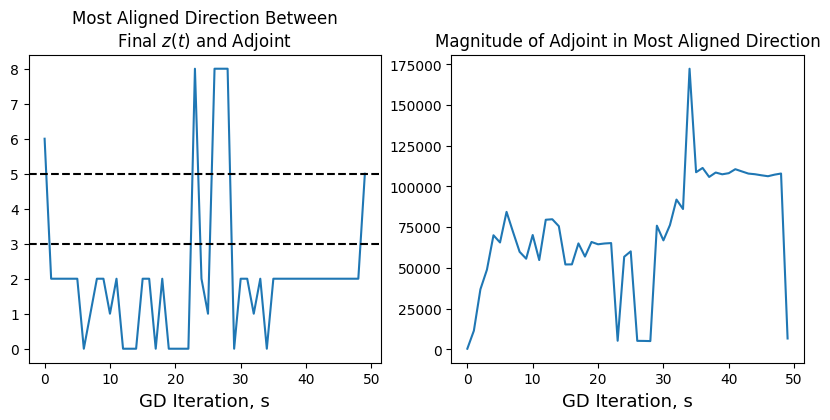

In [ ]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(most_aligned)
plt.title('Most Aligned Direction Between\nFinal $z(t)$ and Adjoint')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.axhline(3, color = 'black', linestyle = 'dashed')
plt.axhline(5, color = 'black', linestyle = 'dashed')

plt.subplot(1,2,2)
plt.plot(mags)
plt.title('Magnitude of Adjoint in Most Aligned Direction')
plt.xlabel('GD Iteration, s', fontsize = 13)
plt.show()

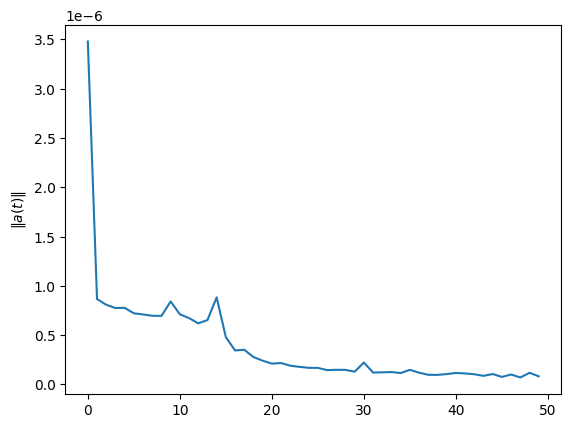

In [74]:
plt.plot([np.mean(np.linalg.norm(a0, axis=2), (0, 1)) for z0, a0 in pairs])
plt.ylabel('$\\|a(t)\\|$')
# plt.yscale('log')
plt.show()

In [14]:
# Evaluate the model on each subtask throughout training and see if the adjoints scales/alignments inform this accuracy.
grouped_losses = []
grouped_adj_norms = []
grouped_components = []
for ch in tqdm(checkpoints_all):
    _, hidden, adjoint, out, _, _, loss_unreduced = eval(ch) # Hidden shape is (B, T, H)
    loss_split = split_data(splits, loss_unreduced)
    adj_split = split_data(splits, adjoint)
    grouped_losses.append([loss_sub.mean().item() for loss_sub in loss_split.values()])
    grouped_adj_norms.append([np.linalg.norm(adj_sub,axis=2).mean((0,1)) for adj_sub in adj_split.values()])

    # Adjoint components
    grouped_components.append([get_components(adj_sub.reshape((-1, adj_sub.shape[-1])), k = 8) for adj_sub in adj_split.values()])

grouped_components = np.array(grouped_components) # [GD steps, 4 (task count), components, hidden size]

100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


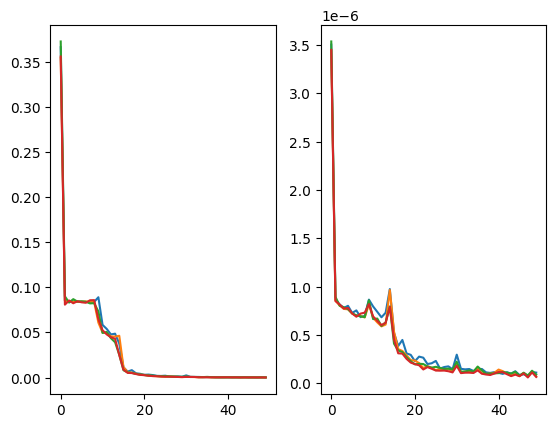

(50, 6, 8, 8)


<Figure size 640x480 with 0 Axes>

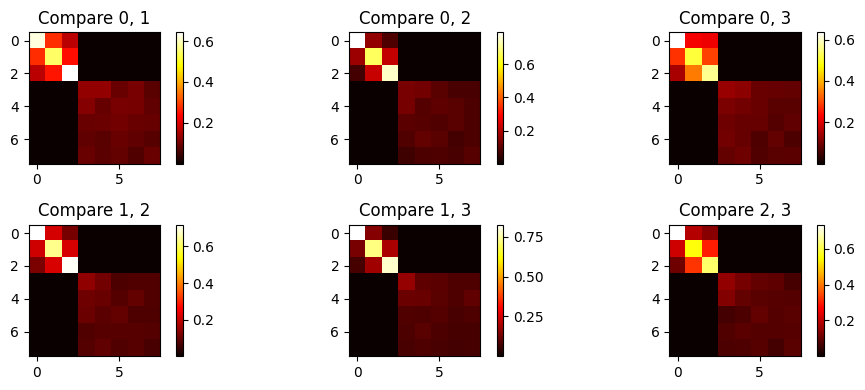

In [17]:
plt.subplot(1,2,1)
plt.plot(grouped_losses)
plt.subplot(1,2,2)
plt.plot(grouped_adj_norms)
plt.show()

plt.figure()
compare_inds = np.array([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]])
similarity = np.zeros((grouped_components.shape[0], compare_inds.shape[0], grouped_components.shape[2], grouped_components.shape[2])) + np.pi/2
print(similarity.shape)
for n in range(len(compare_inds)):
    for i in range(grouped_components.shape[2]):
        for j in range(grouped_components.shape[2]):
            task1, task2 = compare_inds[n] # Tasks to compare
            sim = np.abs(angle_between(grouped_components[:, task1, i], grouped_components[:, task2, j]) - np.pi/2) / (np.pi/2)
            # sim = np.abs((grouped_components[:, :, i, None, :] @ grouped_components[:, :, j, :, None])[:, :, 0, 0])
            similarity[:, n, i, j] = sim

plt.figure(figsize = (10, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(similarity.mean(0)[i], cmap = 'hot')
    plt.title(f'Compare {compare_inds[i,0]}, {compare_inds[i,1]}')
    plt.colorbar()
plt.tight_layout()
plt.show()